<a href="https://colab.research.google.com/github/yoonkim97/pytorch-resnet-mnist/blob/master/MNISTResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
import inspect
import time
from torch import nn, optim
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import urllib
from torch.nn import functional as F

In [2]:

num_workers = 0
batch_size = 20
basepath = '.'

def set_header_for(url, filename):
    opener = urllib.request.URLopener()
    opener.addheader('User-Agent', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36')
    opener.retrieve(
    url, f'{basepath}/{filename}')

set_header_for('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
set_header_for('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods
  from ipykernel import kernelapp as app


In [0]:
class MnistResNet(ResNet):
  def __init__(self):
    super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
    self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  def forward(self, x):
    return torch.softmax(super(MnistResNet, self).forward(x), dim=-1)

In [0]:
train_label_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8]
test_label_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def get_same_indices(target, labels):
  label_indices = []
  for i in range (len(target)):
    for j in range (len(labels)):
      if target[i] == labels[j]:
        label_indices.append(i)
  return label_indices

In [0]:
def get_data_loaders(train_batch_size, val_batch_size):
  mnist = MNIST(download=True, train=True, root=".").train_data.float()
    
  data_transform = Compose([Resize((224, 224)),ToTensor(), Normalize((mnist.mean()/255,), (mnist.std()/255,))])

  train_dataset = MNIST(download=True, root=".", transform=data_transform, train=True)
  train_indices = get_same_indices(train_dataset.targets, train_label_classes)
  train_loader = DataLoader(dataset = train_dataset, batch_size=train_batch_size, shuffle=False, sampler=torch.utils.data.sampler.SubsetRandomSampler(train_indices))

  val_dataset = MNIST(download=False, root=".", transform=data_transform, train=False)
  val_indices = get_same_indices(val_dataset.targets, test_label_classes)
  val_loader = DataLoader(dataset = val_dataset, batch_size=val_batch_size, shuffle=False, sampler=torch.utils.data.sampler.SubsetRandomSampler(val_indices))
  return train_loader, val_loader

In [0]:
def calculate_metric(metric_fn, true_y, pred_y):
  if "average" in inspect.getfullargspec(metric_fn).args:
    return metric_fn(true_y, pred_y, average="macro")
  else:
    return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
  for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
    print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


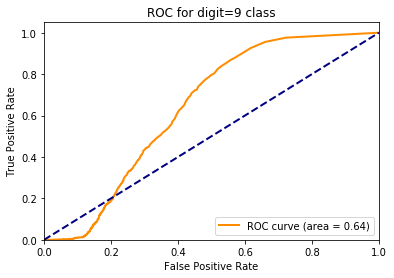

Epoch 1/5, training loss: 1.650789219253468, validation loss: 1.9377144575119019
[[   6    0  929    0    6    0    0    1   38    0]
 [   0  560  305    7   38  122    0   29   74    0]
 [   0    0 1030    0    0    0    0    2    0    0]
 [   0    0   44  964    0    0    0    2    0    0]
 [   0    0   61    0  909    3    0    9    0    0]
 [   0    0  367  102    6  416    0    1    0    0]
 [   0    0  846    0   12   31   63    0    6    0]
 [   0    1  132    9   18    0    0  868    0    0]
 [   0    0  213  116   32   24    0   28  561    0]
 [   0    0   89   25  424   19    0  451    1    0]]
	     precision: 0.5617
	        recall: 0.5316
	            F1: 0.4706
	      accuracy: 0.5368


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


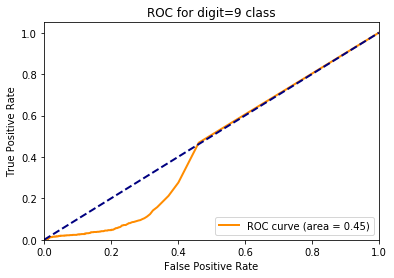

Epoch 2/5, training loss: 1.478314752848643, validation loss: 1.6276384592056274
[[ 972    0    1    0    2    0    3    2    0    0]
 [   3 1109    5    0   12    1    2    2    1    0]
 [   2    0 1017    0   10    0    1    2    0    0]
 [   3    0  175  797    7    0    0   27    1    0]
 [   0    0    0    0  982    0    0    0    0    0]
 [  35    0   45    1   14  763   26    5    3    0]
 [  11    2    2    0   17    1  924    0    1    0]
 [   0    1    6    0   10    0    0 1010    1    0]
 [  36    0   12    0   96    0    1    3  826    0]
 [  24    1    7    0  946    0    0   24    7    0]]
	     precision: 0.8035
	        recall: 0.8396
	            F1: 0.8073
	      accuracy: 0.8408


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


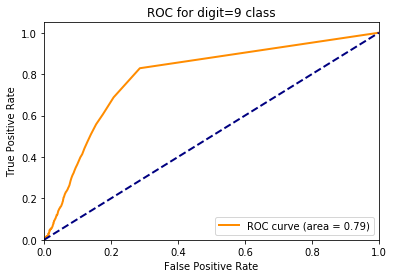

Epoch 3/5, training loss: 1.4723827524005242, validation loss: 1.791419267654419
[[ 970    1    3    0    3    0    2    1    0    0]
 [   0 1126    7    0    0    0    0    2    0    0]
 [   4    0 1004    0    0    0    2   22    0    0]
 [   7    0  869    0    0    9    0  125    0    0]
 [   0    3    1    0  938    0    2   38    0    0]
 [ 211    1   19    0    0  622   26   13    0    0]
 [  15    6    0    0    7    2  928    0    0    0]
 [   0    2    2    0    0    0    0 1024    0    0]
 [ 575    1  167    0   27   11   82   51   60    0]
 [  69    3   13    0   69   35    0  820    0    0]]
	     precision: 0.5981
	        recall: 0.6638
	            F1: 0.5730
	      accuracy: 0.6691


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


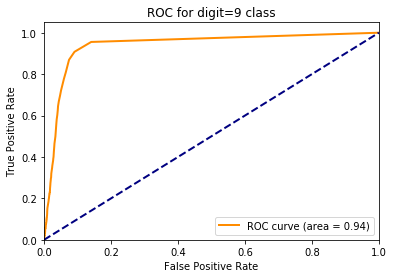

Epoch 4/5, training loss: 1.469533749346463, validation loss: 1.5722695589065552
[[ 978    0    0    0    0    0    0    2    0    0]
 [   0 1133    2    0    0    0    0    0    0    0]
 [   1    6 1013    0    2    0    4    6    0    0]
 [   0    3    1  986    0    9    0    8    3    0]
 [   0    6    0    0  972    0    2    2    0    0]
 [   1    0    0    2    0  888    1    0    0    0]
 [  12    9    1    0    0    2  934    0    0    0]
 [   0   12    4    0    2    0    0 1010    0    0]
 [   3    3    1    0    7    2    0    2  956    0]
 [  46   10    2    1  709   14    1  212   14    0]]
	     precision: 0.8201
	        recall: 0.8848
	            F1: 0.8452
	      accuracy: 0.8882


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


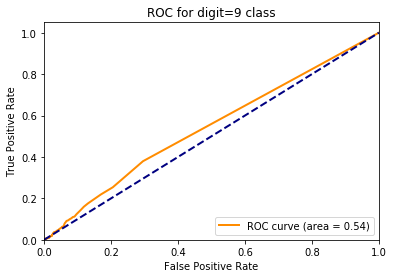

Epoch 5/5, training loss: 1.4667418514782529, validation loss: 1.810013771057129
[[ 81   0 733   1  17   0   1   0 147   0]
 [  0 665   9   1 449   5   0   0   6   0]
 [  0   0 979  49   2   0   0   0   2   0]
 [  0   0  24 968   2   1   0   0  15   0]
 [  0   0   6   0 967   0   0   0   9   0]
 [  0   0  24 105   4 627   0   0 132   0]
 [  0   2  61   0  11   1 814   0  69   0]
 [  0   1  56 119 392   0   0 426  34   0]
 [  0   0   0  12   1   0   0   0 961   0]
 [  0   0  72  44 580   0   0   0 313   0]]
	     precision: 0.7052
	        recall: 0.6499
	            F1: 0.5939
	      accuracy: 0.6482
[1.650789219253468, 1.478314752848643, 1.4723827524005242, 1.469533749346463, 1.4667418514782529]
Training time: 975.469265460968s


In [19]:
start_ts = time.time()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 5

model = MnistResNet().to(device)
train_loader, val_loader = get_data_loaders(256, 256)


losses = []
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters())

batches = len(train_loader)
val_batches = len(val_loader)

# training loop + eval loop
for epoch in range(epochs):
    total_loss = 0
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)
    model.train()
    
    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)
        
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)

        loss.backward()
        optimizer.step()
        current_loss = loss.item()
        total_loss += current_loss
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))
        
    torch.cuda.empty_cache()
    
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []
    
    confusion_actuals = []
    probabilities = []
    predictions = []
    roc_actuals = []

    which_class = 9

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)
            outputs = model(X)
            prediction = outputs.argmax(dim=1, keepdim=True)
            confusion_actuals.extend(y.view_as(prediction))
            roc_actuals.extend(y.view_as(prediction) == which_class)
            probabilities.extend(np.exp(outputs.cpu()[:, which_class]))  
            predictions.extend(prediction)

            val_losses += loss_function(outputs, y)

            predicted_classes = torch.max(outputs, 1)[1]
            
            for acc, metric in zip((precision, recall, f1, accuracy), 
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )
    confusion_actuals = [i.item() for i in confusion_actuals]
    predictions = [i.item() for i in predictions]
    roc_actuals = [i.item() for i in roc_actuals]
    class_probabilities = [i.item() for i in probabilities]


    fpr, tpr, _ = roc_curve(roc_actuals, class_probabilities)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2 
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for digit=%d class' % which_class)
    plt.legend(loc="lower right")
    plt.show()
        
    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print(confusion_matrix(confusion_actuals, predictions))    
    print_scores(precision, recall, f1, accuracy, val_batches)
    losses.append(total_loss/batches)
print(losses)
print(f"Training time: {time.time()-start_ts}s")


In [0]:
class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    def set_temperature(self, valid_loader):
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece = ece_criterion(logits, labels).item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self

In [0]:
class _ECELoss(nn.Module):
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

In [22]:
scaled_model = ModelWithTemperature(model)
scaled_model.set_temperature(val_loader)
# model_filename = 'model_with_temperature.pth'
# torch.save(scaled_model.state_dict(), model_filename)
# print('Temperature scaled model saved to %s', model_filename)
# print('Done!')

Before temperature - NLL: 1.810, ECE: 0.430
Optimal temperature: 0.257
After temperature - NLL: 1.365, ECE: 0.130


ModelWithTemperature(
  (model): MnistResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine